In [118]:
import os
from deep_dating.datasets import DatasetName, DatingDataLoader, SetType, CrossVal, CLaMM, MPS
from deep_dating.networks import DatingCNN, DatingTrainer, Autoencoder
from deep_dating.util import DATASETS_PATH
from deep_dating.prediction import DatingPredictor
from preprocessing import preprocess_autoencoder, preprocess_dating_cnn
from sklearn.manifold import TSNE
from deep_dating.metrics import DatingMetrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os 
import shutil
from deep_dating.util import DATASETS_PATH
import cv2
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np

In [119]:
run_path =  "runs/auto/" #"runs/Jan8-19-25-16/" #"runs/Jan6-22-21-16/" #"runs/Dec21-16-31-47"
model_name = "model_epoch_24"
all_labels_, all_outputs_, all_paths_ = DatingPredictor().load(os.path.join(run_path, model_name + "_feats_train_mps.pkl"))
all_labels_val_, all_outputs_val_, all_paths_val_ = DatingPredictor().load(os.path.join(run_path, model_name + "_feats_val_mps.pkl"))

In [120]:
all_labels = all_labels_.flatten()
print(all_labels)
all_labels_val = all_labels_val_.flatten()
print(all_labels_val)

[1525. 1375. 1300. ... 1450. 1500. 1525.]
[1400. 1525. 1375. ... 1550. 1500. 1450.]


In [121]:
labels = np.unique(all_labels_)
labels

array([1300., 1325., 1350., 1375., 1400., 1425., 1450., 1475., 1500.,
       1525., 1550.], dtype=float32)

In [137]:
all_outputs_.shape

tsne = TSNE(n_components=2)
#tsne = PCA(n_components=2)
features_tsne_2d = tsne.fit_transform(all_outputs_)

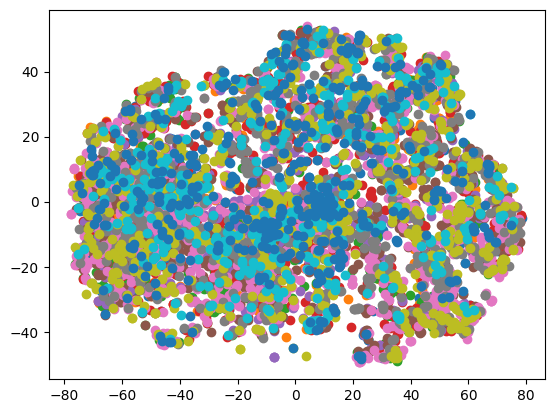

In [147]:
for l in labels:
    idxs = np.where(all_labels_ == l)[0]
    plt.scatter(features_tsne_2d[idxs, 0], features_tsne_2d[idxs, 1])
plt.show()

In [148]:
svm = SVC()
svm.fit(all_outputs_, all_labels)

SVC()

In [149]:
val_predict_labels = svm.predict(all_outputs_val_)

alphas = [0, 25, 50, 100, 150]
metrics = DatingMetrics(alphas=alphas)
metrics.names

vals = metrics.calc(all_labels_val, val_predict_labels)

mae, mse = tuple(vals[:2])
cs_ = vals[2:]
# print(cs_)

# plt.plot(alphas, cs_)
# plt.xlabel("Alpha Value")
# plt.ylabel("Cumulative Score")
# plt.ylim(0, 100)
# plt.xticks(np.arange(0, 55, 5))
# plt.axvline(x=25, color="red")
# plt.show()

print(mae, mse)
print([0, 25])
print(cs_)

54.458887545344616 5535.444377267231
[0, 25]
[25.090689238210402, 46.31197097944377, 62.87787182587666, 85.61064087061668, 96.19105199516325]


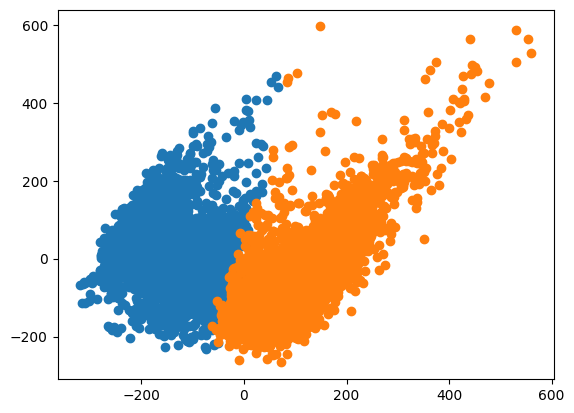

In [127]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(all_outputs_)
kmeans.labels_
# os.mkdir("group_0")
# os.mkdir("group_1")

paths = np.array(all_paths_)

for i in range(2):
    idxs = np.where(kmeans.labels_ == i)[0]

    # for path in paths[idxs]:
    #     img_name = os.path.basename(path)
    #     path = os.path.join(DATASETS_PATH, "CLAMM_Set_Auto_Bin", img_name)
    #     shutil.copy(path, os.path.join(f"group_{i}", img_name))

    plt.scatter(features_tsne_2d[idxs, 0], features_tsne_2d[idxs, 1])
plt.show()

In [ ]:
import torch

model_path = "runs/auto/model_epoch_24.pt" #"runs/Jan8-19-25-16/model_epoch_3.pt"

model = Autoencoder()
model.load(model_path, continue_training=False)

imgs = [os.path.join(DATASETS_PATH, "MPS_Set_Auto/MPS1500_0347__10_1500_p1.ppm")]

patches = [model.transform_img(x) for x in imgs]
patches = torch.from_numpy(np.array(patches))

output = model(patches)
output = output.cpu().detach().numpy()

Model loading completed!


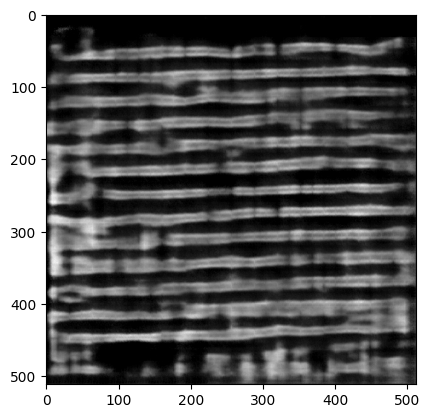

In [ ]:
plt.imshow(output[0, 0, :, :], cmap="gray")
plt.show()